# LDA Topic Modeling

Topic modelling is a technique to extract hidden topics from large volume of text. 

LDA represents topics as word probabilities and allows for uncovering hidden topics as it clusters words based ontheir co-occurrence in a respective document.

### Assumptions for LDA
1. Documents with similar topics use similar groups of words
2. Latent topics can be found by searching for groups of words that frequently occur together in documents across corpus
3. Documents are probability distributions over latent topics that signifies certain document will contain more words of specific topic
4. Topics themselves are probability distribution over words

### Goal: To find out what users speak about

One can use any vectorizer and not just count vectorizer e.g. tfidf - experiment!

### Steps that we will follow:
1. Prepare data
2. Find optimal number of topics
3. Fit optimal model
4. Transform training data and assign topics
5. Transform entire dataset and plot topics over time

In [4]:
# Setting to ignore warnings
import warnings
warnings.filterwarnings("ignore")


# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import nltk
import numpy as np
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation

# Text processing libraries
import re
from nltk.corpus import stopwords
import emoji
import contractions  # from https://github.com/kootenpv/contractions
import string

pd.set_option('display.max_colwidth', 100)

## 1 Prepare Data

In [5]:
# Read data and clean a bit
spotify = pd.read_csv("../data/raw/spotify_review_kaggle.csv")
data_in = spotify.copy()
data_in = data_in.drop_duplicates(subset="Review")  # Drop dupes in Reviews
data_in.drop(["Time_submitted", "Total_thumbsup",
             "Reply"], axis=1, inplace=True)
data_in["Length"] = data_in["Review"].str.split(" ").str.len()
data_in = data_in[data_in.Length < 150]
data_in.drop(["Length"], axis=1, inplace=True)
data = data_in
data.head(10)

,Review,Rating
0,"Great music service, the audio is high quality and the app is easy to use. Also very quick and f...",5
1,Please ignore previous negative rating. This app is super great. I give it five stars+,5
2,"This pop-up ""Get the best Spotify experience on Android 12"" is too annoying. Please let's get ri...",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't put on my playlist??? And why do we have shuffle p...,1
5,The player controls sometimes disappear for no reason. App restart forgets what I was playing bu...,3
6,I love the selection and the lyrics are provided with the song you're listening to!,5
7,Still extremely slow when changing storage to external sd card.. I'm convinced this is done on p...,3
8,"It's a great app and the best mp3 music app I have ever used but there is one problem that, why ...",5
9,"I'm deleting this app, for the following reasons: This app now has a failing business model. Whe...",1


In [6]:
## Define a function to do some text cleaning
def clean_text(text):
    text = emoji.demojize(text)  # fix emojis
    text = contractions.fix(text)  # fix contractions
    text = re.sub(r'[^\x00-\x7f]', r'', text)  # remove strange fonts
    text = re.sub(r"\d+", "number", text)  # replace numbers with "number"
    text = re.sub(r'[^\w\s]', '', text)  # remove non-alphanumeric chars
    text = re.sub(r'\b\w{1}\b', '', text) # remove words less than 3 characters
    text = text.replace('_', ' ')  # replace underscores with space
    text = text.strip()  # strip extra spaces
    return text.lower()

In [7]:
## Test our text cleaner
clean_text("I ❤️ Spotify, even though it is critizised for exploiting artists")

'red heart spotify even though it is critizised for exploiting artists'

In [8]:
## Apply to all data
data["Review"] = data["Review"].apply(clean_text)

In [9]:
## Tokenize/remove punctuations
tokenizer = RegexpTokenizer(r'\w+')

In [10]:
data["Tokens"] = data["Review"].apply(tokenizer.tokenize)

In [11]:
data.sample(10)

,Review,Rating,Tokens
53167,excellent app very useful and instinctive to use,5,"[excellent, app, very, useful, and, instinctive, to, use]"
25703,love spotify can find all the music like and make different lists can connect it to my alexa ...,5,"[love, spotify, can, find, all, the, music, like, and, make, different, lists, can, connect, it,..."
36548,serious bugs as at numbernumbernumber liked songs not syncing major annoyance playback controls ...,1,"[serious, bugs, as, at, numbernumbernumber, liked, songs, not, syncing, major, annoyance, playba..."
23216,think something broke in the app as the playpause button is suddenly off to the left side instea...,3,"[think, something, broke, in, the, app, as, the, playpause, button, is, suddenly, off, to, the, ..."
9687,it do not turn off when go to different apps,5,"[it, do, not, turn, off, when, go, to, different, apps]"
34108,the auto shuffle sucks would be nice if you would bring back the old way of playing musics like ...,2,"[the, auto, shuffle, sucks, would, be, nice, if, you, would, bring, back, the, old, way, of, pla..."
47803,have used this app for years now and will never use anything else it is just perfect for me and...,5,"[have, used, this, app, for, years, now, and, will, never, use, anything, else, it, is, just, pe..."
28299,does not save my place on podcasts since the last update,1,"[does, not, save, my, place, on, podcasts, since, the, last, update]"
13824,hands down the best way to listen to music absolutely love this app,5,"[hands, down, the, best, way, to, listen, to, music, absolutely, love, this, app]"
56138,definitely the worst music streaming app have ever used with full service or on wifi there shou...,1,"[definitely, the, worst, music, streaming, app, have, ever, used, with, full, service, or, on, w..."


In [12]:
# Get NLTK English stopwords
our_stopwords = set(stopwords.words('english'))
additional_stopwords = ["spotify", "app", "apps", "music", "songs", "song"]
our_stopwords.update(additional_stopwords)
#our_stopwords.remove("not")
# Remove stopwords
# We loop through each list of words and remove stopwords
data['Tokens'] = data['Tokens'].apply(lambda x: [word for word in x if word not in (our_stopwords)])
data.sample(5)

,Review,Rating,Tokens
26390,great music streaming app but crashes multiple times day make me sad,3,"[great, streaming, crashes, multiple, times, day, make, sad]"
21625,this afternoon got glitch where the ui button moved but it did not affect the audio quality,4,"[afternoon, got, glitch, ui, button, moved, affect, audio, quality]"
24348,it is easy to use but stop adding things to my play lists,2,"[easy, use, stop, adding, things, play, lists]"
57952,app works just ok glitchy sometimes whether have good cellular or wifi connection is there se...,3,"[works, ok, glitchy, sometimes, whether, good, cellular, wifi, connection, setting, missing, aut..."
17932,terrible app would only connect to internet to take my payment details but not for the service i...,1,"[terrible, would, connect, internet, take, payment, details, service, offers, waste, time]"


In [13]:
## Split data in train and test
X_train, X_test = train_test_split(data['Tokens'], test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape)

(46009,) (15337,)


In [14]:
## Count Vectorizer
def dummy(doc):
    return doc

count_vectorizer = CountVectorizer(tokenizer=dummy, preprocessor=dummy, max_features = 10000, ngram_range = (1,3))

X_train_counts = count_vectorizer.fit_transform(X_train)


In [15]:
## make TFIDF matrix
tfidf_vectorizer = TfidfTransformer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_counts)

In [16]:
## Get number of features from vectorizer and it shall match number of features that we provide to it
len(count_vectorizer.get_feature_names())

10000

In [17]:
# #! pip install tmtoolkit
# from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
# # lda_model - LatentDirichletAllocation()
# # vect - CountVectorizer()
# # texts - the list of tokenized words
# metric_coherence_gensim(measure='c_v', 
#                         top_n=25, 
#                         topic_word_distrib=LDA.components_, 
#                         dtm=X_train_counts, 
#                         vocab=np.array([x for x in count_vectorizer.vocabulary_.keys()]), 
#                         texts=data_train["Tokens"])

## 2 Find optimal number of topics

In [18]:
# Search for ideal number of topics;
# Takes about 13 minutes
n_topics = [2,4,6,8,10,12,16,20,30,50,75,100]

perplexities = []
log_likelihood = []
# gensim_metrics = []
for n_topic in n_topics:
    LDA = LatentDirichletAllocation(n_components=n_topic,random_state=42)
    LDA.fit(X_train_tfidf)

    perplexities.append(LDA.perplexity(X_train_counts))
    log_likelihood.append(LDA.score(X_train_counts))

In [19]:
lda_results = pd.DataFrame(
    {'N_Topics': n_topics,
     'Perplexity': perplexities,
     'LLH': log_likelihood}
    )
lda_results

,N_Topics,Perplexity,LLH
0,2,2309.699865,-6.454260e+06
1,4,2130.943891,-6.387130e+06
2,6,2127.108591,-6.385629e+06
3,8,2151.372570,-6.395081e+06
4,10,2200.344867,-6.413839e+06
5,12,2235.053760,-6.426882e+06
6,16,2323.649392,-6.459277e+06
7,20,2352.623588,-6.469605e+06
8,30,2621.345625,-6.559738e+06
9,50,2943.759711,-6.656407e+06


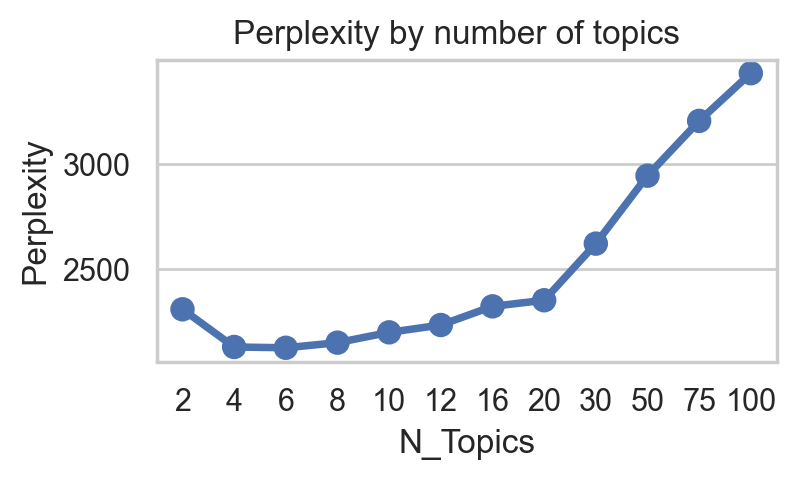

In [20]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(4,2),dpi=200)

plt.suptitle("Perplexity by number of topics");
sns.pointplot(x="N_Topics",
              y="Perplexity",
              data=lda_results);

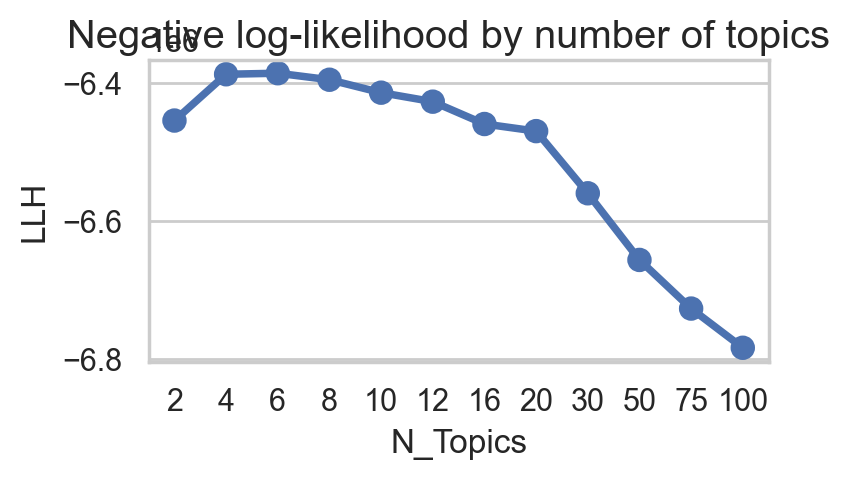

In [21]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(4,2),dpi=200)

plt.suptitle("Negative log-likelihood by number of topics");
sns.pointplot(x="N_Topics",
              y="LLH",
              data=lda_results);

## 3. Fit optimal model

In [22]:
## Final model
LDA = LatentDirichletAllocation(n_components=6,random_state=42)
LDA.fit(X_train_tfidf)

LatentDirichletAllocation(n_components=6, random_state=42)

In [23]:
## Number of components (=topics)
n_components = len(LDA.components_)
print("Number of components: ", n_components)

Number of components:  6


In [24]:
# print n top words per component
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([count_vectorizer.get_feature_names()[index] for index in (-topic).argsort()[:15]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['number', 'ads', 'premium', 'would', 'like', 'get', 'playlist', 'free', 'every', 'ad', 'listen', 'many', 'one', 'stars', 'pay']


THE TOP 15 WORDS FOR TOPIC #1
['playing', 'update', 'stop', 'keeps', 'play', 'fix', 'bar', 'pause', 'phone', 'stops', 'randomly', 'cannot', 'last', 'bugs', 'please']


THE TOP 15 WORDS FOR TOPIC #2
['cannot', 'even', 'account', 'downloaded', 'offline', 'internet', 'fix', 'log', 'working', 'play', 'connection', 'tried', 'premium', 'please', 'work']


THE TOP 15 WORDS FOR TOPIC #3
['play', 'want', 'listen', 'like', 'good', 'playlist', 'cannot', 'love', 'plays', 'great', 'want listen', 'one', 'hear', 'random', 'even']


THE TOP 15 WORDS FOR TOPIC #4
['great', 'easy', 'good', 'use', 'easy use', 'quality', 'love', 'podcasts', 'selection', 'sound', 'amazing', 'nice', 'excellent', 'like', 'experience']


THE TOP 15 WORDS FOR TOPIC #5
['best', 'love', 'face', 'good', 'smiling', 'ever', 'favorite', 'streaming', 'listen', 'listening', 'g

In [25]:
## Let's give a descriptive name to the topics
lda_topics = ['too_many_ads', 'phone_update_issue', 'download_connection_issue', 'only_random_in_playlists', 'spotify_is_awesome', 'best_streaming']

In [26]:
# turn this into a handy df
def get_model_topics(model, vectorizer, topics, n_top_words=10):    
    word_dict = {}    
    feature_names = vectorizer.get_feature_names()    
    for topic_idx, topic in enumerate(model.components_):        
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]        
        top_features = [feature_names[i] for i in top_features_ind]        
        word_dict[topics[topic_idx]] = top_features
    return pd.DataFrame(word_dict)

In [27]:
get_model_topics(LDA, count_vectorizer, lda_topics)

,too_many_ads,phone_update_issue,download_connection_issue,only_random_in_playlists,spotify_is_awesome,best_streaming
0,number,playing,cannot,play,great,best
1,ads,update,even,want,easy,love
2,premium,stop,account,listen,good,face
3,would,keeps,downloaded,like,use,good
4,like,play,offline,good,easy use,smiling
5,get,fix,internet,playlist,quality,ever
6,playlist,bar,fix,cannot,love,favorite
7,free,pause,log,love,podcasts,streaming
8,every,phone,working,plays,selection,listen
9,ad,stops,play,great,sound,listening


## 4. Transform training data and assign topics

In [28]:
topic_results = LDA.transform(X_train_tfidf)
topic_results

array([[0.03189069, 0.09966361, 0.03182942, 0.03217787, 0.66296618,
        0.14147223],
       [0.03561589, 0.31491265, 0.03580542, 0.03556287, 0.03566186,
        0.54244131],
       [0.24263338, 0.02487565, 0.02472886, 0.62237116, 0.06002503,
        0.02536592],
       ...,
       [0.0352571 , 0.03525369, 0.82347969, 0.03578759, 0.03508042,
        0.03514151],
       [0.42133949, 0.03115063, 0.03121271, 0.03131318, 0.45360197,
        0.03138202],
       [0.05715735, 0.05687477, 0.05688162, 0.05700789, 0.05711415,
        0.71496422]])

In [29]:
# Split original data
data_train, _ = train_test_split(data, test_size=0.25, random_state=42)

In [30]:
pd.set_option('display.max_colwidth', 150)
data_train['Topic_number'] = topic_results.argmax(axis=1)
data_train[["Review", "Topic_number"]].head(10)

,Review,Topic_number
29893,great app best music platform but the group session feature needs work still they should add controll feature that let us someone be host of the ...,4
29959,spotifys best feature is the notifications for new releases by artists you follow but that feature has not been working for months after several u...,5
54863,would have gave number stars if spotify completely supported joe rogans freedom of expression and did not delete those number episodes am not fa...,3
54056,have to uninstall and reinstall multiple times to receive any new music podcast etc very buggy and have android lol,1
24842,good quantity of music and quality,4
2890,my experience with spotify is great love this platform thanks spotify team,4
9323,great to be able to create own playlist from number of choices,5
34086,there is one request for spotify please add recently added songs,0
38814,highly suggest not getting this have tried number months now to cancel my subscription it says its canceled yet they keep taking funds from me tr...,2
60771,really liked spotify at first but then it got updated or something and now it has gotten very annoying cannot enter my playlists to pick songs th...,0


In [31]:
# log-likelihood (measure of how plausible model parameters are given the data); lower is better 
# (it is actually NEGATIVE LLH; as every metric in sklearn is implemented so that lower is better)
print(LDA.score(X_train_counts))
# Perplexity (a measure of model's "surprise" at the data); lower is better
print(LDA.perplexity(X_train_counts))

-6385629.060841522
2127.10859086184


In [32]:
def assign_topic_name(topic_number):
    if topic_number == 0:
        return lda_topics[0]
    if topic_number == 1:
        return lda_topics[1]
    if topic_number == 2:
        return lda_topics[2]
    if topic_number == 3:
        return lda_topics[3]
    if topic_number == 4:
        return lda_topics[4]
    if topic_number == 5:
        return lda_topics[5]


data_train["Topic_name"] = data_train["Topic_number"].apply(assign_topic_name)

In [33]:
data_train[["Review", "Topic_name"]].sample(10)

,Review,Topic_name
50003,lately have to force close and restart the app numbernumber time before it actually works not worth paying premium for this android version numbe...,phone_update_issue
59389,love this app so much keep my airpods in numbernumber,best_streaming
53690,love this music app we never have any issues with loading or finding new music or podcasts easy to navigate easy to give ratings on podcasts love it,spotify_is_awesome
46283,spotify is not letting me login please solve this issue,download_connection_issue
35223,great options and you can take it wherever you want thumbs up,spotify_is_awesome
46521,have been using this app for the past number months in premium and can say that it is good but then after months this march number literally ju...,too_many_ads
4445,listened to podcast with nancy grace have missed her she is on different channel now still great speaker and trying to put killers behind bars...,too_many_ads
19270,good app if you have premium if you cannot afford premium probably just get sound cloud,spotify_is_awesome
42148,overall great app picked it up because am cancelling xm radio and will be using this app instead,only_random_in_playlists
15330,even if it is great on ipad and computer cannot say the same for my phone find it really stupid that cannot play the song want and only can pl...,only_random_in_playlists


In [34]:
topic_f = pd.DataFrame(data_train["Topic_name"].value_counts()).reset_index()
topic_f.columns = ["Topic_name", "Count"]
topic_f

,Topic_name,Count
0,too_many_ads,10347
1,phone_update_issue,8479
2,best_streaming,6958
3,only_random_in_playlists,6868
4,download_connection_issue,6726
5,spotify_is_awesome,6631


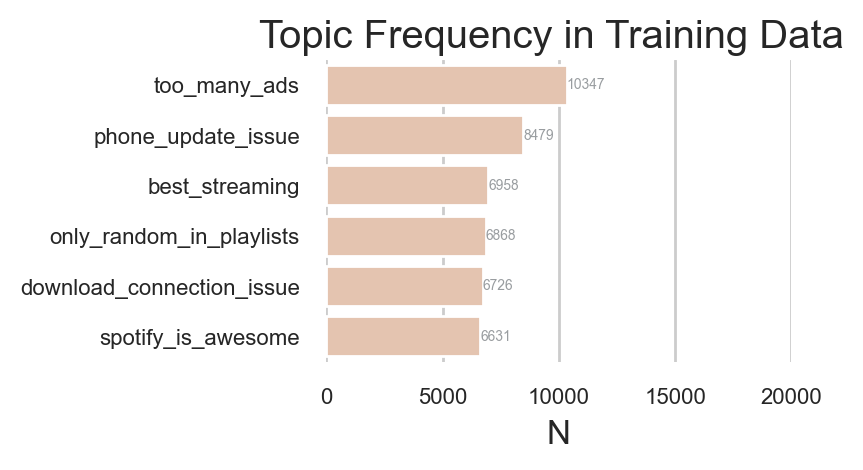

In [35]:
## Plot
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(3,2),dpi=200)

sns.set_color_codes("pastel")
sns.barplot(x="Count", 
            y="Topic_name", 
            data=topic_f,
            color = "#EDC2A7")

ax.set(xlim=(0, 20000), ylabel="",
       xlabel="N")
ax.bar_label(ax.containers[0], size=5, label_type="edge", padding=0, color="#999DA0")
plt.suptitle("Topic Frequency in Training Data")

ax.tick_params(labelsize=8)

sns.despine(left=True, bottom=True)

## 5. Transform entire dataset and plot topics over time

In [36]:
## define pipeline to predict a topic from a single input
def predict_topic(text):
    text_clean = clean_text(text)
    tokens = tokenizer.tokenize(text_clean)
    tokens_clean = [word for word in tokens if word not in (our_stopwords)]
    counts = count_vectorizer.transform([tokens_clean])
    tfids = tfidf_vectorizer.transform(counts)
    topics = LDA.transform(tfids)
    topic = topics.argmax(axis=1).flat[0]
    topic_name = lda_topics[topic]
    return topic_name


In [37]:
predict_topic("I downloaded this app yesterday great playlists")

'spotify_is_awesome'

In [38]:
# Read data and clean a bit
spotify = pd.read_csv("../data/raw/spotify_review_kaggle.csv")
ts_data = spotify.copy()
ts_data = ts_data.drop_duplicates(subset="Review")  # Drop dupes in Reviews
ts_data.drop(["Total_thumbsup",
             "Reply"], axis=1, inplace=True)
ts_data["Length"] = ts_data["Review"].str.split(" ").str.len()
ts_data = ts_data[ts_data.Length < 150]
ts_data.drop(["Length"], axis=1, inplace=True)
ts_data["Time_submitted"] = pd.to_datetime(ts_data["Time_submitted"])
ts_data["Topic"] = ts_data["Review"].apply(predict_topic)

In [39]:
ts_data.sample(10)

,Time_submitted,Review,Rating,Topic
1531,2022-07-06 08:36:06,Full with Entertainment,5,best_streaming
47677,2022-03-06 16:17:27,"I am running spotify, I have an error message at the bottom of the screen saying, ""no internet connection available."" however, I am connected to t...",2,download_connection_issue
4202,2022-06-30 09:41:53,"There's some issue with this app on my phone, it isn't getting opened, could you please assist",3,download_connection_issue
55127,2022-02-05 02:33:41,Seems like a lot of pod cast are missing lately.,1,phone_update_issue
48467,2022-03-02 21:31:54,I'm disappointed with this app... I tried everything to get my songs to appear on my car radio and nothing.. fix this...,5,phone_update_issue
28606,2022-04-27 00:43:45,Volume of ads is 30-50% higher than that of songs . Ads are so loud that listening has become annoying unfortunately,1,too_many_ads
58955,2022-01-23 21:35:40,"This app allows you to listen to any of your favorite songs online. You can turn your phone, tablet, off and it will save your phone or tablet bat...",5,best_streaming
25747,2022-05-04 17:25:43,"Great service, but the way they have changed the app with the last few updates is terrible. Was so much better a year ago. Updating my review as t...",1,phone_update_issue
5087,2022-06-28 11:57:40,there awesome but the only thing that is not good is that you have to have data or internet so if your traveling and don't have data you can't pla...,3,download_connection_issue
51279,2022-02-19 00:36:58,Very Happy with my experience. Easy to use & good music selection.,5,spotify_is_awesome


In [40]:
ts_df = ts_data.resample('W', on='Time_submitted')['Topic'].value_counts()
ts_df = pd.DataFrame(ts_df)
ts_df.columns = ["Topic_count"]
ts_df = ts_df.reset_index()
ts_df.columns = ["Week", "Topic", "Topic_count"]

ts_df = ts_df.pivot_table('Topic_count', ['Week'], 'Topic').reset_index()
ts_df["Week"] = ts_df["Week"].astype(str)
ts_df.head(10)

Topic,Week,best_streaming,download_connection_issue,only_random_in_playlists,phone_update_issue,spotify_is_awesome,too_many_ads
0,2022-01-02,10,12,14,8,9,35
1,2022-01-09,26,56,64,56,49,160
2,2022-01-16,102,108,128,127,82,242
3,2022-01-23,190,192,255,198,168,367
4,2022-01-30,311,212,567,267,318,554
5,2022-02-06,297,268,504,252,325,552
6,2022-02-13,275,241,347,257,305,488
7,2022-02-20,261,247,321,242,295,453
8,2022-02-27,260,209,265,221,253,432
9,2022-03-06,209,246,248,231,207,388


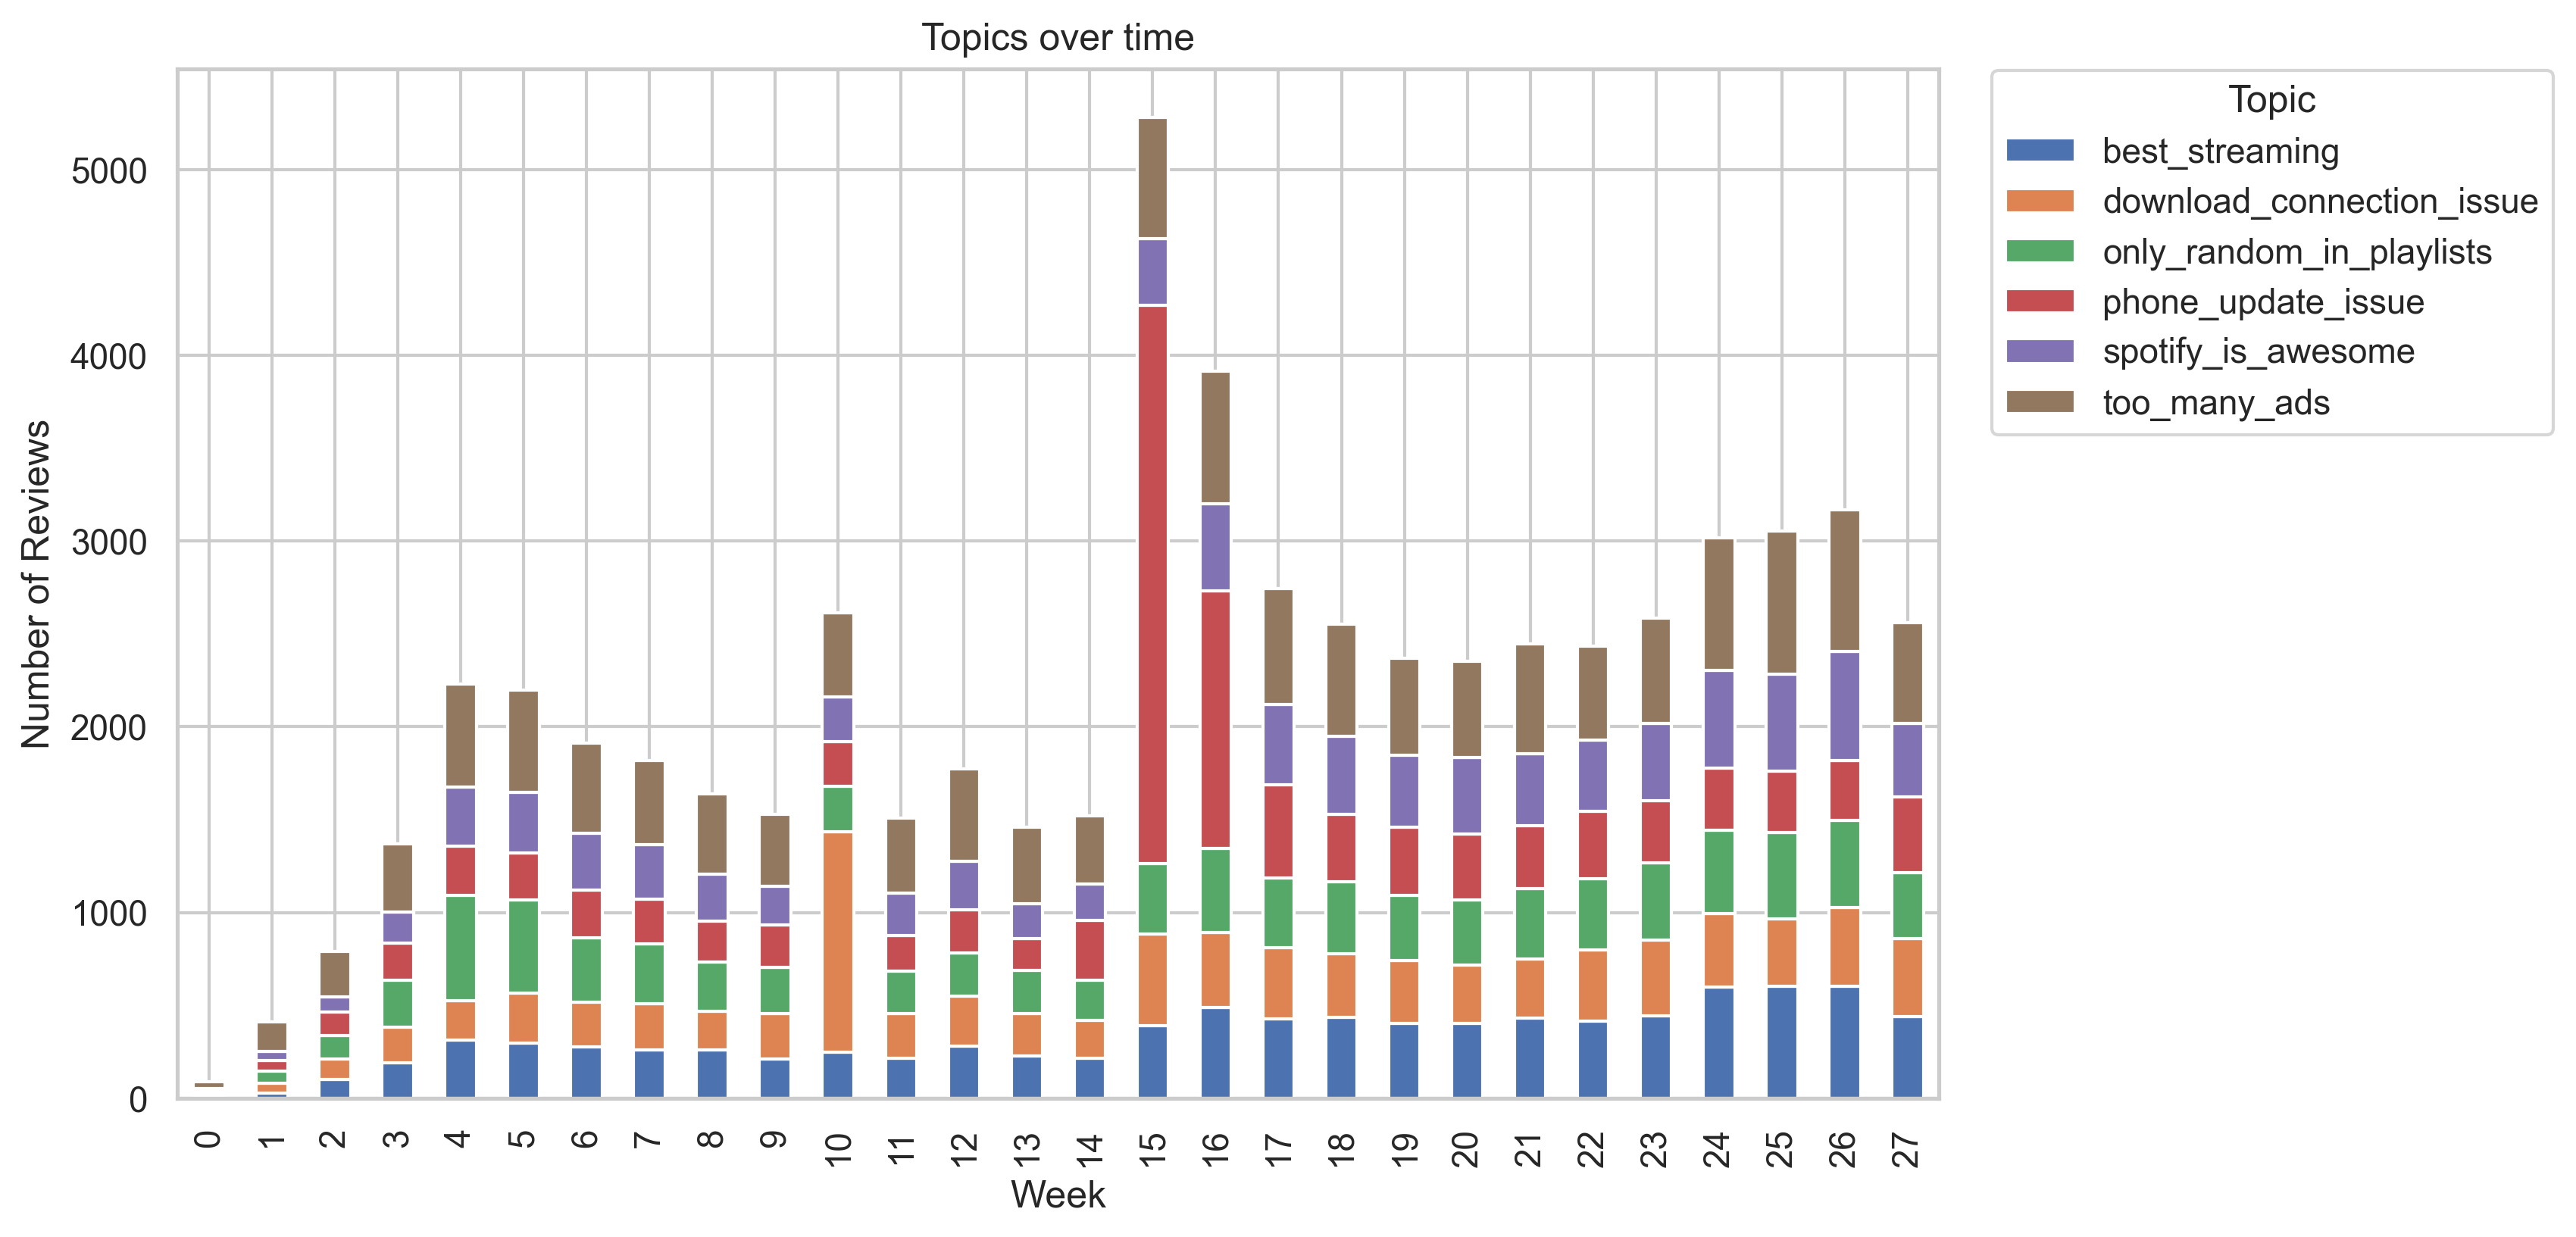

In [41]:
# plot the pivoted dataframe
plt.rcParams['figure.dpi'] = 300
ts_df.plot.bar(stacked=True, figsize=(10, 6), ylabel='Number of Reviews', xlabel='Week', title='Topics over time')
plt.legend(title='Topic', bbox_to_anchor=(1.02, 1.015), loc='upper left')
plt.show()

In [42]:
ts_df.head()

Topic,Week,best_streaming,download_connection_issue,only_random_in_playlists,phone_update_issue,spotify_is_awesome,too_many_ads
0,2022-01-02,10,12,14,8,9,35
1,2022-01-09,26,56,64,56,49,160
2,2022-01-16,102,108,128,127,82,242
3,2022-01-23,190,192,255,198,168,367
4,2022-01-30,311,212,567,267,318,554


In [43]:
ts_df_props = ts_df

ts_df_props[lda_topics] = ts_df[lda_topics].div(ts_df[lda_topics].sum(axis=1), axis=0).multiply(100)
ts_df_props.head()

Topic,Week,best_streaming,download_connection_issue,only_random_in_playlists,phone_update_issue,spotify_is_awesome,too_many_ads
0,2022-01-02,11.363636,13.636364,15.909091,9.090909,10.227273,39.772727
1,2022-01-09,6.326034,13.625304,15.571776,13.625304,11.922141,38.929440
2,2022-01-16,12.927757,13.688213,16.223067,16.096324,10.392902,30.671736
3,2022-01-23,13.868613,14.014599,18.613139,14.452555,12.262774,26.788321
4,2022-01-30,13.952445,9.510991,25.437416,11.978466,14.266487,24.854195


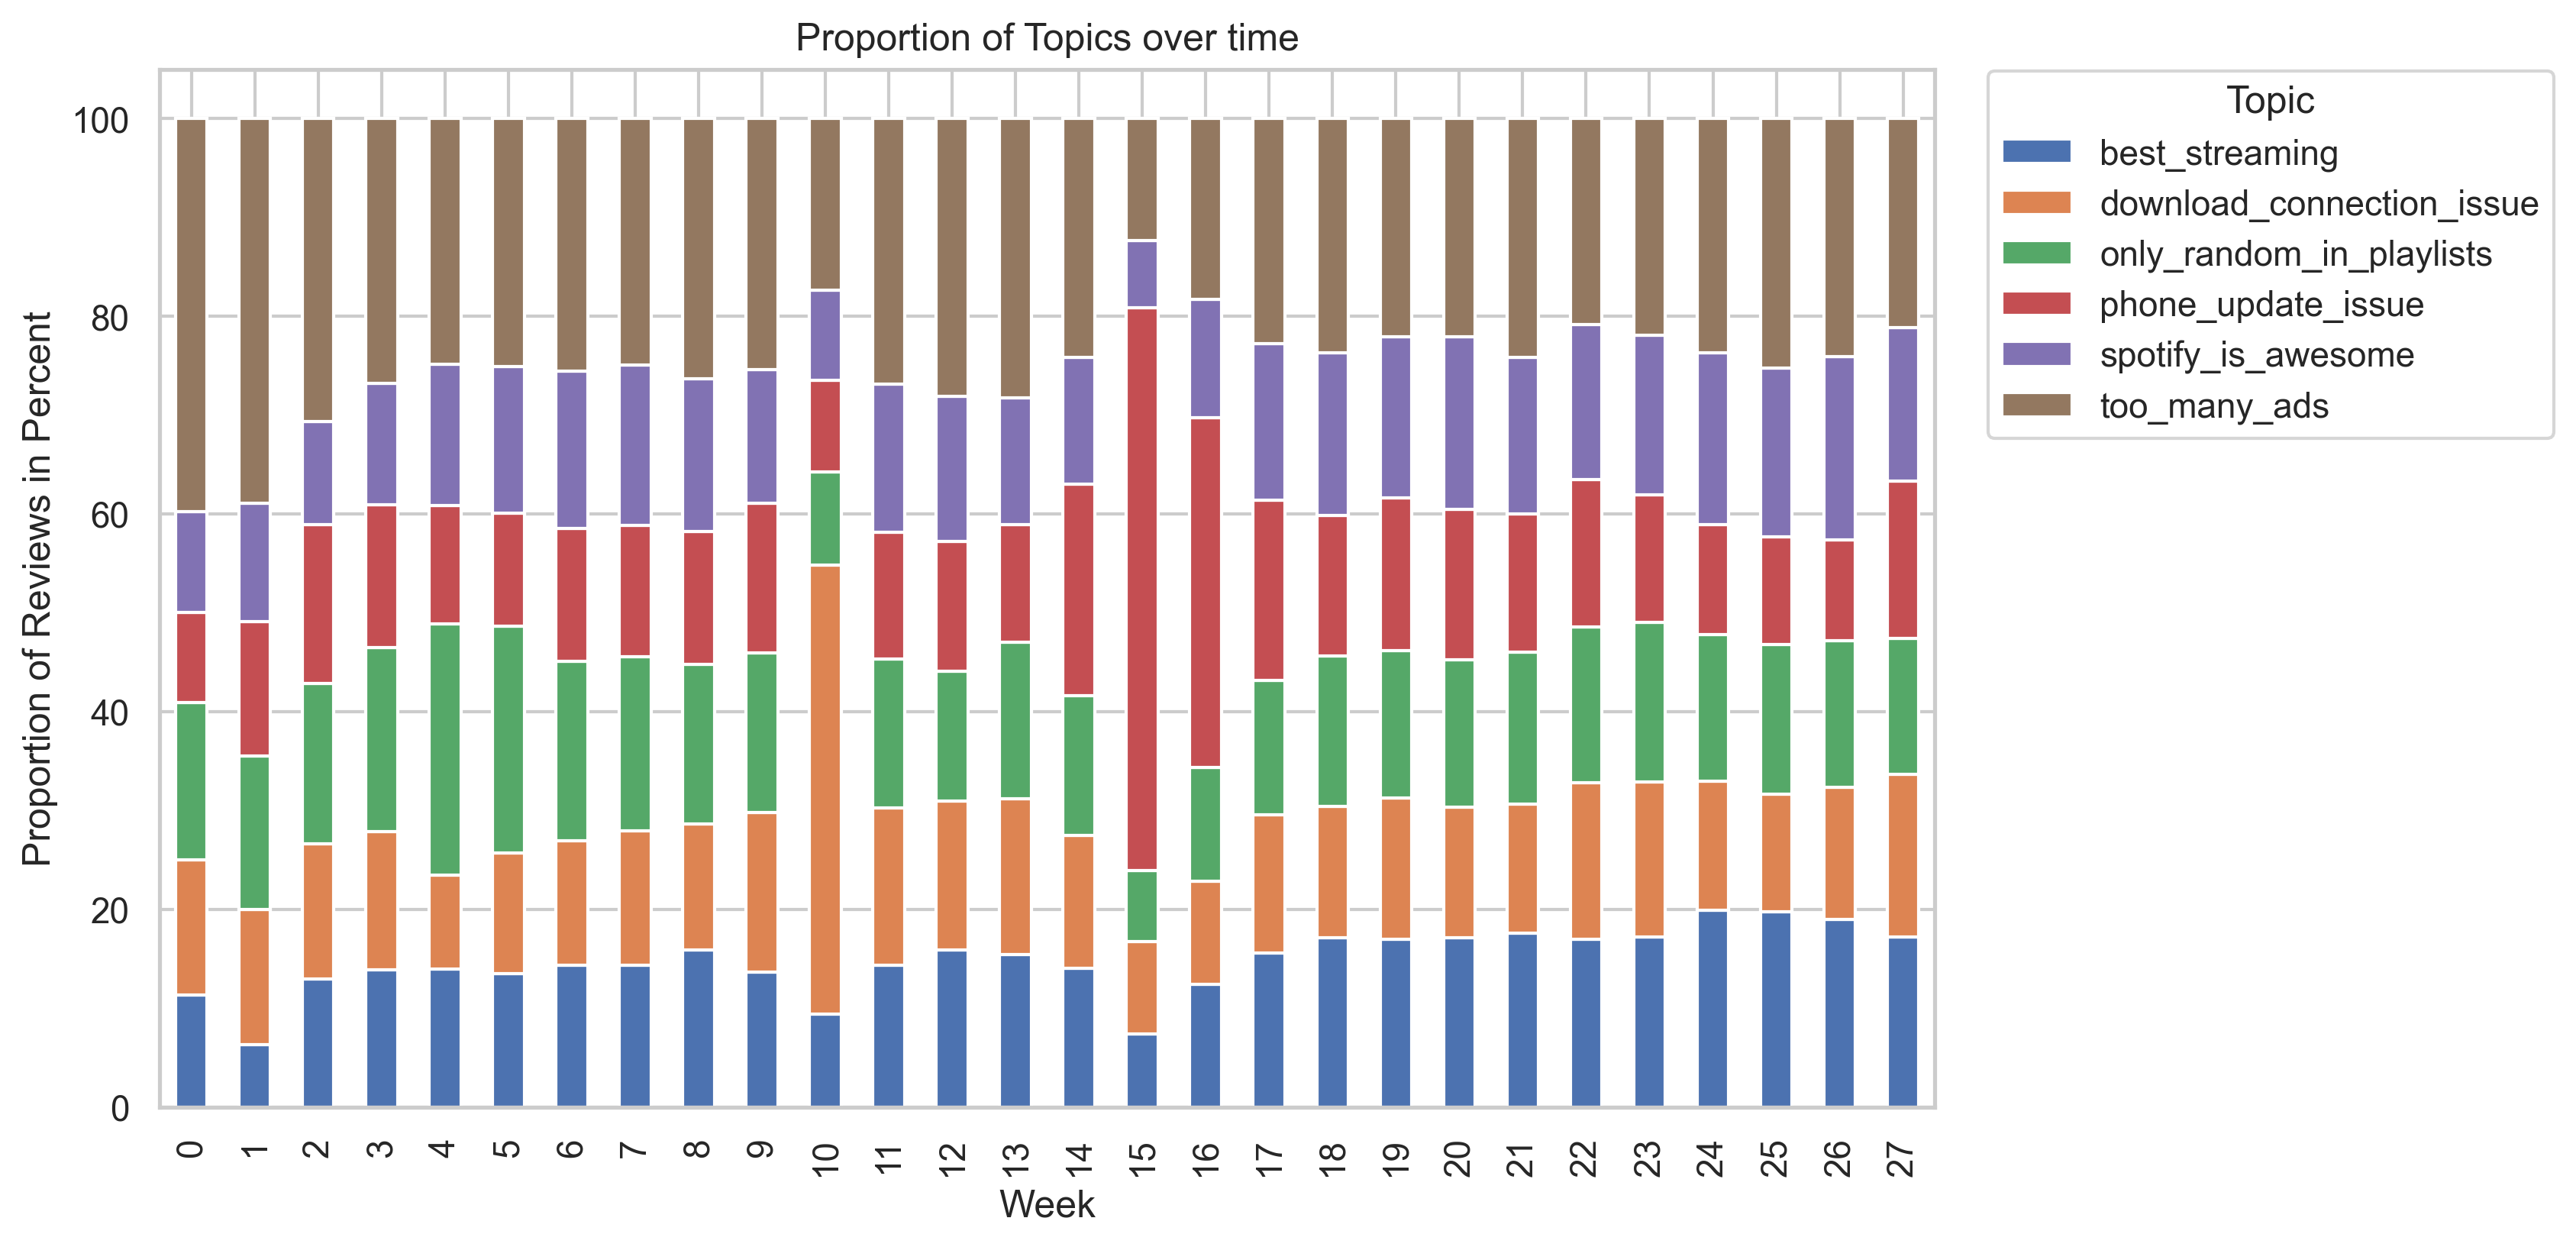

In [44]:
# plot the pivoted dataframe
plt.rcParams['figure.dpi'] = 300
ts_df_props.plot.bar(stacked=True, figsize=(10, 6), ylabel='Proportion of Reviews in Percent', xlabel='Week', title='Proportion of Topics over time')
plt.legend(title='Topic', bbox_to_anchor=(1.02, 1.015), loc='upper left')
plt.show()